In [1]:
#!rm -rf /home/jovyan/work/notebooks/ied/data/Planet/planet_mike_resized
!nvidia-smi


Thu Nov  4 19:55:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   35C    P2    61W / 300W |   1323MiB / 11018MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import torch
from torch import nn
import torch.nn.functional as F
import torch.cuda as cuda

from torch.utils.data import DataLoader
from pytorch_toolbelt import losses as L
import albumentations as A
from segmentation_models_pytorch.utils import metrics
import pytorch_lightning as pl
from matplotlib.pylab import plt
import random
from tqdm.notebook import tqdm


from code.nikita_eval.evaluate import get_metrics
from code.models import ResBlock,ConvBlock, DeconvBlock, DenseBlock
from code.networks import UnetGenerator
from code.engine import get_loaders


def set_seed(seed=77):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.set_deterministic(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
SAVE_NAME = 'unet_first'    
    
    
N_FEAT = 512
INPUT_SIZE = [256,256]
INPUT_CHANNELS = 4
BATCH = 2
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'
NORM = nn.BatchNorm2d

def wrapper(class_,norm):
    def set_default_norm_layer(*args,**kwargs):
        return class_(*args,**kwargs,norm_layer=norm)
    return set_default_norm_layer

ConvBlock = wrapper(ConvBlock,NORM)
ResBlock = wrapper(ResBlock,NORM)
DeconvBlock = wrapper(DeconvBlock,NORM)
DenseBlock = wrapper(DenseBlock,nn.BatchNorm2d)

In [2]:
class ContentEncoder(nn.Module):
    def __init__(self,**kwargs):
        super(ContentEncoder,self).__init__()
        modules = [ConvBlock(64,7,1,padding=0),
                   ConvBlock(128,4,2),
                   ConvBlock(256,4,2),
                   ConvBlock(N_FEAT,4,2),
                   ResBlock(N_FEAT,),
                   ResBlock(N_FEAT,),
                   ResBlock(N_FEAT,),
                   ResBlock(N_FEAT,),
                  ]
        self.module = nn.Sequential(*modules)
        
    def forward(self,x):
        return self.module(x)
    
class StyleEncoder(nn.Module):
    def __init__(self,**kwargs):
        super(StyleEncoder,self).__init__()
        encoder = [ConvBlock(64,7,1,padding=3),
                   ConvBlock(128,4,2),
                   ConvBlock(256,4,2),
                   ConvBlock(512,4,2),
                   ConvBlock(1024,4,2),
                   nn.AdaptiveAvgPool2d(1),
                   nn.Flatten(),
                  ]
        
        self.encoder = nn.Sequential(*encoder)
        
        shift = [DenseBlock(512),
                 DenseBlock(N_FEAT),
                ]
        self.shift = nn.Sequential(*shift)
        
        scale = [DenseBlock(512),
                 DenseBlock(N_FEAT),
                ]
        self.scale = nn.Sequential(*scale)
        
        self.momentum = kwargs.get('momentum',0.05)
        self.register_buffer('glob_shift',torch.zeros([N_FEAT,1,1]))
        self.register_buffer('glob_scale',torch.ones([N_FEAT,1,1]))
        
    def update_state(self,shift,scale):
        shift = shift.reshape([BATCH,N_FEAT,1,1])
        scale = scale.reshape([BATCH,N_FEAT,1,1])

        self.glob_shift = self.glob_shift*(1-self.momentum)+shift.detach().mean(0)*self.momentum
        self.glob_scale = self.glob_scale*(1-self.momentum)+scale.detach().mean(0)*self.momentum
        
    def forward(self,x):
        if self.training:
            encoded = self.encoder(x)
            shift, scale = self.shift(encoded), self.scale(encoded)
            shift = shift.reshape([BATCH,N_FEAT,1,1])
            scale = scale.reshape([BATCH,N_FEAT,1,1])

            self.update_state(shift,scale)
            return shift, scale
        else:
            return self.glob_shift, self.glob_scale
    

class Decoder(nn.Module):
    def __init__(self,**kwargs):
        super(Decoder,self).__init__()
        decoder = [DeconvBlock(256,4,2,padding=0),
                   DeconvBlock(128,4,2,padding=0),
                   DeconvBlock(64,4,2,padding=0),
                   ConvBlock(4,7,1,padding=0,activation=nn.Tanh),
                  ]
        
        self.decoder = nn.Sequential(*decoder)

        
    def forward(self,x):
        decoded = self.decoder(x)
        return decoded    
    
    
class AdaIN(nn.Module):
    def __init__(self,**kwargs):
        super(AdaIN,self).__init__()
        self.norm = nn.InstanceNorm2d(N_FEAT,momentum=1,affine=False)
            
    def transform(self,x,shift,scale):
        normed = self.norm(x)
        return normed*scale+shift
        
    def forward(self,x,shift,scale):
        transformed = self.transform(x,shift,scale)
        return transformed
    
    


In [3]:
class MyUnetGenerator(nn.Module):
    def __init__(self,**kwargs):
        super(MyUnetGenerator,self).__init__()
        self.unet = UnetGenerator(INPUT_CHANNELS,INPUT_CHANNELS,6)
        self.styleA = StyleEncoder()
        self.styleB = StyleEncoder()
        
    
    def forward(self,pic,style_pic,to_domain):
        if to_domain in ['A',0]:
            style = self.styleA(style_pic)
        elif to_domain in ['B',1]:
            style = self.styleB(style_pic)
        new_pic = self.unet(pic,style)
        return new_pic
    
    
class Generator(nn.Module):
    def __init__(self,**kwargs):
        super(Generator,self).__init__()
        self.encoder = ContentEncoder()
        self.styleA = StyleEncoder()
        self.styleB = StyleEncoder()
        self.adain = AdaIN()
        self.decoder = Decoder()
    
    def forward(self,pic,style_pic,to_domain):
        content = self.encoder(pic)
        if to_domain in ['A',0]:
            style = self.styleA(style_pic)
        elif to_domain in ['B',1]:
            style = self.styleB(style_pic)
        new_content = self.adain(content,*style)
        new_pic = self.decoder(new_content)
        return new_pic
        
class Discriminator(nn.Module):
    def __init__(self,**kwargs):
        super(Discriminator,self).__init__()
        module = [ConvBlock(64,4,2),
                   ConvBlock(128,4,2),
                   ConvBlock(256,4,2),
                   ConvBlock(512,4,2),
                   ConvBlock(1024,4,2),
                   ConvBlock(2048,4,2)
                  ]
        
        self.module = nn.Sequential(*module)
        self.critique = ConvBlock(1,3,1,activation=nn.Identity)
        
        self.domain = ConvBlock(1,4,1,padding=0,activation=nn.Sigmoid)
        
    def forward(self,x):
        z = self.module(x)
        return self.critique(z).mean((-2,-1)), self.domain(z).mean((-2,-1))

In [4]:
content = ContentEncoder().to(DEVICE)
style = StyleEncoder().to(DEVICE)
adain = AdaIN().to(DEVICE)
decoder = Decoder().to(DEVICE)

discr = Discriminator().to(DEVICE)
gen = Generator().to(DEVICE)
ugen = MyUnetGenerator().to(DEVICE)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
def test_run():
    test_img = np.random.uniform(size=[BATCH,INPUT_CHANNELS]+INPUT_SIZE)
    inp = torch.tensor(test_img).float().to(DEVICE)
    print('inp: ',inp.shape)
    
    content_out = content(inp)
    print('content: ',content_out.shape)
    style_out = style(inp)
    print('style: ',style_out[0].shape,style_out[1].shape)
    adain_out = adain(content_out,*style_out)
    print('adain', adain_out.shape)
    decoder_out = decoder(adain_out)
    print('decoder', decoder_out.shape)
    
    gen_out = gen(inp,inp,1)
    print('gen', gen_out.shape)
    ugen_out = ugen(inp,inp,1)
    print('ugen',ugen_out.shape)
    discr_out = discr(ugen_out)
    print('discr', discr_out[0].shape,discr_out[1].shape)
    
    
test_run()

inp:  torch.Size([2, 4, 256, 256])
content:  torch.Size([2, 512, 31, 31])
style:  torch.Size([2, 512, 1, 1]) torch.Size([2, 512, 1, 1])
adain torch.Size([2, 512, 31, 31])
decoder torch.Size([2, 4, 256, 256])
gen torch.Size([2, 4, 256, 256])
ugen torch.Size([2, 4, 256, 256])
discr torch.Size([2, 1]) torch.Size([2, 1])


In [4]:
class Logger:
    def __init__(self):
        self.container = {}
        self.epoch_start = 0
        
    def __getitem__(self,key):
        if key not in self.container.keys():
            self.container[key] = []
        return self.container[key]
    
    def update_state(self,state:dict):
        for i,k in state.items():
            if hasattr(k,'__len__'):
                self[i].extend(k)
            else:
                self[i].append(k)
    
    def end_epoch(self):
        self.epoch_start = len(list(self.container.values())[0])
    
    def get_average(self):
        try:
            out = {}
            for i,k in self.container.items():
                if i.startswith('_no_avg_'):
                    continue
                out[i] = sum(k[self.epoch_start:])/(len(k)-self.epoch_start)
            return out
        except Exception as e:
            print(e)
            return {k:0 for k in self.container.keys()}
        

In [43]:
class Trainer:
    def __init__(self, G=None,D=None, lr=0.0002,max_epochs=20, decay_start=10, device=DEVICE):
        assert decay_start < max_epochs
        
        self.device = device
        
        self.G = Generator().to(self.device) if G is None else G.to(self.device)
        self.D = Discriminator().to(self.device) if D is None else D.to(self.device)
        
        self.opt_G = torch.optim.Adam(self.G.parameters(),lr=lr) 
        self.opt_D = torch.optim.Adam(self.D.parameters(),lr=lr)

        self.opt_sch_G = torch.optim.lr_scheduler.LambdaLR(
            self.opt_G,
            lambda x: max(1E-6,min(1,(max_epochs-x)/(max_epochs-decay_start))),
            verbose=True
        )
        self.opt_sch_D = torch.optim.lr_scheduler.LambdaLR(
            self.opt_D,
            lambda x: max(1E-6,min(1,(max_epochs-x)/(max_epochs-decay_start))),
            verbose=True
        )
        
        def preproc_true(true,pred):
            true = torch.tensor(true,dtype=pred.dtype)
            true = true.expand_as(pred).to(pred.device)
            return true
            
        def cust_mse(pred,true):
            true = preproc_true(true,pred)
            return nn.MSELoss()(pred,true)
        
        def cust_bce(pred,true):
            true = preproc_true(true,pred)
            return nn.BCELoss()(pred,true)
        self.mse = cust_mse
        self.l1 = nn.L1Loss()
        self.bce = cust_bce
        

    
    def fit(self, train_data, epochs=20):
        self.data = train_data
        self.logger = Logger()
        
        self.sample = self._batch_to_device(train_data.dataset[12])
        
        for epoch in range(epochs):
            self.run_epoch(epoch)
            
            self.opt_sch_D.step()
            self.opt_sch_G.step()
            
            self.end_epoch()
            
    def run_epoch(self,epoch):
        self.G.train()
        self.D.train()
        epoch_average_loss = {}
        for i, batch in enumerate(self.data):
            self.opt_G.zero_grad()
            self.opt_D.zero_grad()

            with torch.autograd.set_detect_anomaly(True):
                D_loss, G_loss = self.training_step(batch)
            
                D_loss.backward(retain_graph=True)
                G_loss.backward()
            self.opt_G.step()
            self.opt_D.step()
            
            stat = {'D_loss':D_loss.item(),
                    'G_loss':G_loss.item(),
                    'lr':self.opt_sch_D.get_last_lr(),
                   }
            self.logger.update_state(stat)
            avg = self.logger.get_average()

            print(f"Epoch {epoch}: {i}/{len(self.data)} DLoss: {avg['D_loss']}, GLoss: {avg['G_loss']}, lr: {avg['lr']}",end='\r')
        print('\n')
    
    def training_step(self, batch):
        batch = self._batch_to_device(batch)
        x, xtrue, xmask, y, ytrue, ymask = batch
        # real section
        x_src, x_cls = self.D(x)
        y_src, y_cls = self.D(y)
        
        # fake section | 0, A - sentinel; 1,B - planet
        x_fake = self.G(x,y,1)
        y_fake = self.G(y,x,0)
        x_fake_src, x_fake_cls = self.D(x_fake)
        y_fake_src, y_fake_cls = self.D(y_fake)
        
        # reconstruction section
        x_rec = self.G(x,x,0)
        y_rec = self.G(y,y,1)
        
        x_fake_fake = self.G(x_fake,y_fake,0)
        y_fake_fake = self.G(y_fake,x_fake,1)
        
        D_loss = [
                 1*(self.mse(x_src,1)+self.mse(y_src,1))/2, # real adv mse
                 1*(self.bce(x_cls,0)+self.bce(y_cls,1))/2, # real only domain classification
                 1*(self.mse(x_fake_src,0)+self.mse(y_fake_src,0))/2 # fake adv mse
                 ]
        D_loss = sum(D_loss)
        
        G_loss = [
                 1*(self.mse(x_fake_src,1)+self.mse(y_fake_src,1))/2, # fake adv mse
                 1*(self.bce(x_fake_cls,1)+self.bce(y_fake_cls,0))/2, # fake only domain classification
                 10*(self.l1(x,x_rec)+self.l1(y,y_rec))/2, # reconstruction l1
                 10*(self.l1(x,x_fake_fake)+self.l1(y,y_fake_fake))/2 # fake reconstruction l1
                 ]
        G_loss = sum(G_loss)
        
        return D_loss, G_loss
    
    def end_epoch(self):
        self.logger.end_epoch()
            
        self.data.dataset.inner_shuffle() # reshuffle after each epoch
        
        self.G.eval()
        def get_G_img(inp,style):
            out = self.G(inp.unsqueeze(0),None,style).cpu()/2+1
            out = out.numpy()[0,1:,:,:].transpose([1,2,0])
            return out
        with torch.no_grad():
            self.logger.update_state({'_no_avg_fakePlanet':[get_G_img(self.sample[0],1)]})
            self.logger.update_state({'_no_avg_fakeSentinel':[get_G_img(self.sample[3],0)]})
    
    
    def _batch_to_device(self,batch):
        return tuple([x.to(self.device) for x in batch])

In [6]:
class JointDataset(torch.utils.data.Dataset):
    def __init__(self,datasets,shuffle=False,inner_shuffle=False):
        """
        datasets: iterable of datasets.
        shuffle: indicates whether the zipped dataset should yield tuples in
                 a random order.
        inner_shuffle: indicates whether the datasets should be shuffled relatively to
                       each other. This implies shuffle=True, though these parameters are
                       implemented independently.
        """
        super().__init__()
        self.datasets = list(datasets)
        self.order = np.arange(len(self))
        self.inner_order = [np.arange(len(self)) for _ in self.datasets]
        if inner_shuffle:
            self.inner_shuffle()  
        if shuffle:
            self.shuffle()
        
        
    def __len__(self):
        return min([len(d) for d in self.datasets])
    
    def __getitem__(self,idx):
        idx = self.order[idx]
        output = []
        for i,dataset in enumerate(self.datasets):
            output.extend(dataset[self.inner_order[i][idx]])
                    
        return tuple(output)
    
    def inner_shuffle(self):
        for i, order in enumerate(self.inner_order):
                self.inner_order[i] = np.random.permutation(order)
    
    def shuffle(self):
        self.order = np.random.permutation(self.order)
    
class ExtendDataset(torch.utils.data.Dataset):
    def __init__(self,datasets):
        super().__init__()
        self.datasets = list(datasets)
        
    def __len__(self):
        return sum([len(d) for d in self.datasets])
    
    def __getitem__(self,idx):
        for dataset in self.datasets:
            if idx >= len(dataset):
                idx -= len(dataset)
                continue
            else:
                return dataset[idx]
        raise IndexError('Index out of range')
        
class MapDataset(torch.utils.data.Dataset):
    def __init__(self,dataset,map_fn=lambda x:x):
        super().__init__()
        self.dataset = dataset
        self.map = map_fn
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,idx):
        return self.map(self.dataset[idx])
    
    def inner_shuffle(self):
        try:
            self.dataset.inner_shuffle()
        except AttributeError:
            print('Inner shuffling is not implemented in the child dataset')
        
    def disabled(self,idx):
        return self.dataset[idx]

In [7]:
train_set_sentinel,valid_set_sentinel,test_set_sentinel = get_loaders(
                         root_path='/home/jovyan/work/notebooks/ied/data/Sentinel-2',
                         dataset_name='sentinel_mike',
                         skip_val=False)

train_set_planet,valid_set_planet,test_set_planet = get_loaders(
                         root_path='/home/jovyan/work/notebooks/ied/data/Planet',
                         dataset_name='planet_mike_resized',
                         skip_val=False,sentinel_scale=True)


Dataset has already been created, skipping
Dataset has already been created, skipping
Dataset has already been created, skipping
Dataset has already been created, skipping
Dataset has already been created, skipping
Dataset has already been created, skipping


In [8]:
sentinel_set = ExtendDataset([train_set_sentinel,valid_set_sentinel,test_set_sentinel])
planet_set = ExtendDataset([train_set_planet,valid_set_planet,test_set_planet])

dataset = JointDataset([sentinel_set,planet_set],inner_shuffle=False)
#dataset = JointDataset([valid_set_sentinel,valid_set_planet],inner_shuffle=False) #!!!!!!!!!!!!!!

def map_data(batch):
    x,xt,xm,y,yt,ym = batch
    x = x*2-1
    y = y*2-1
    return x,xt,xm,y,yt,ym
dataset = MapDataset(dataset,map_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


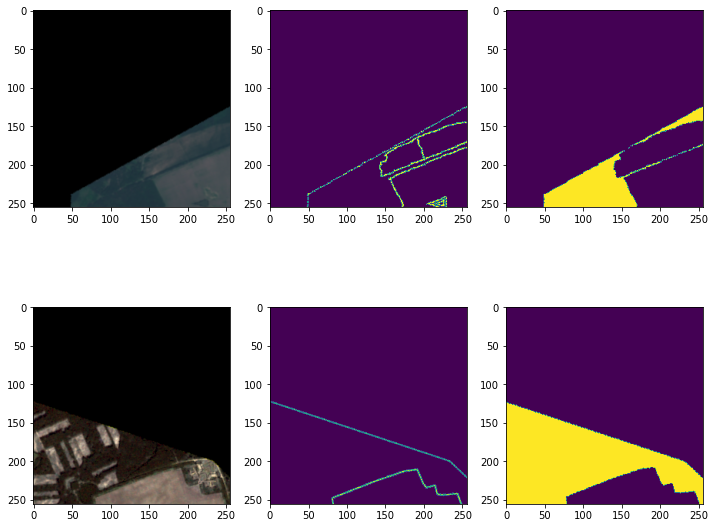

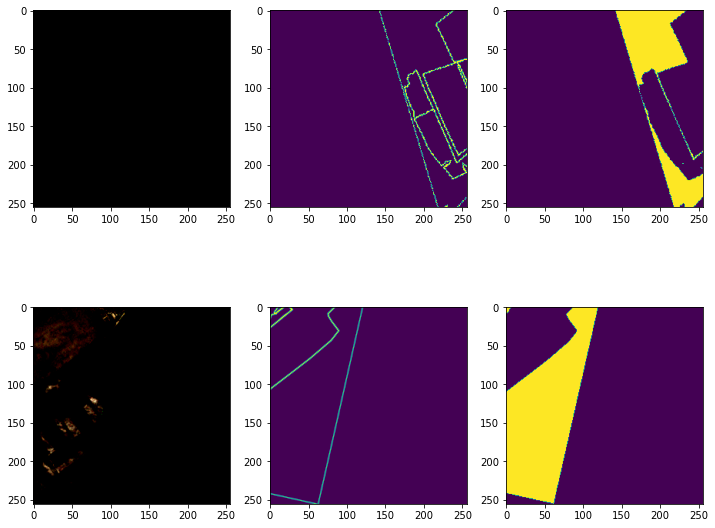

In [9]:
def joint_vis(piece):
    piece  = list(piece)
    piece[0] = np.transpose(piece[0].cpu()[1:],(1,2,0))
    piece[3] = np.transpose(piece[3].cpu()[1:],(1,2,0))
    f,axes = plt.subplots(2,3,figsize=(12,10))
    for i in range(6):
        axes.flatten()[i].imshow(piece[i].cpu())
        
joint_vis(dataset.disabled(0))
joint_vis(dataset[0])

In [10]:
class TrainerBottle:
    def __init__(self, encoder,decoder,lr=0.0002,max_epochs=20, decay_start=10, device=DEVICE):
        assert decay_start < max_epochs
        
        self.device = device
        
        self.model = nn.Sequential(encoder,decoder).to(self.device)
        
        self.opt = torch.optim.Adam(self.model.parameters(),lr=lr) 
        
        self.opt_sch = torch.optim.lr_scheduler.LambdaLR(
            self.opt,
            lambda x: max(1E-6,min(1,(max_epochs-x)/(max_epochs-decay_start))),
            verbose=True
        )
        
        def preproc_true(true,pred):
            true = torch.tensor(true,dtype=pred.dtype)
            true = true.expand_as(pred).to(pred.device)
            return true
            
        def cust_mse(pred,true):
            true = preproc_true(true,pred)
            return nn.MSELoss()(pred,true)
        
        def cust_bce(pred,true):
            true = preproc_true(true,pred)
            return nn.BCELoss()(pred,true)
        self.mse = cust_mse
        self.l1 = nn.L1Loss()
        self.bce = cust_bce
        

    
    def fit(self, train_data, epochs=20):
        self.data = train_data
        self.logger = Logger()
        
        self.sample = self._batch_to_device(train_data.dataset[12])
        
        for epoch in range(epochs):
            self.run_epoch(epoch)
            
            self.opt_sch.step()
            
            self.end_epoch()
            
    def run_epoch(self,epoch):
        self.model.train()
        
        for i, batch in enumerate(self.data):
            self.opt.zero_grad()
            
            with torch.autograd.set_detect_anomaly(True):
                loss = self.training_step(batch)
                loss.backward()
                
            self.opt.step()
            
            stat = {'loss':loss.item(),
                    'lr':self.opt_sch.get_last_lr(),
                   }
            self.logger.update_state(stat)
            avg = self.logger.get_average()

            print(f"Epoch {epoch}: {i}/{len(self.data)} Loss: {avg['loss']}, lr: {avg['lr']}",end='\r')
        print('\n')
    
    def training_step(self, batch):
        batch = self._batch_to_device(batch)
        x, xtrue, xmask, y, ytrue, ymask = batch
        
        xr = self.model(x)
        yr = self.model(y)
        
        loss = (self.l1(x,xr)+self.l1(y,yr))/2 # reconstruction l1
                 
        
        return loss
    
    def end_epoch(self):
        self.logger.end_epoch()
            
        self.data.dataset.inner_shuffle() # reshuffle after each epoch
        
        self.model.eval()
        def get_G_img(inp,style):
            out = self.model(inp.unsqueeze(0)).cpu()/2+1
            out = out.numpy()[0,1:,:,:].transpose([1,2,0])
            return out
        with torch.no_grad():
            self.logger.update_state({'_no_avg_fakePlanet':[get_G_img(self.sample[0],1)]})
            self.logger.update_state({'_no_avg_fakeSentinel':[get_G_img(self.sample[3],0)]})
    
    
    def _batch_to_device(self,batch):
        return tuple([x.to(self.device) for x in batch])

In [44]:
torch.cuda.empty_cache()
G = MyUnetGenerator()
D = Discriminator()

In [45]:
t = Trainer(G,D,device=DEVICE,max_epochs=40)
loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=BATCH,
                                     shuffle=True,
                                     pin_memory=True,
                                     num_workers=6,
                                     drop_last=True,
                                    )

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.


In [46]:
t.fit(loader,epochs=40)

Epoch 0: 86/87 DLoss: 2.0335072566723, GLoss: 8.493235187968988, lr: 0.000200000000000000060176

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 1: 86/87 DLoss: 1.8291192671348309, GLoss: 4.662670204009133, lr: 0.000200000000000000067

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 2: 86/87 DLoss: 1.7284955800264732, GLoss: 3.8932555571369742, lr: 0.00020000000000000006

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 3: 86/87 DLoss: 1.6995645090081226, GLoss: 3.600457997157656, lr: 0.000200000000000000067

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 4: 86/87 DLoss: 1.6708374489312885, GLoss: 3.4116113679162385, lr: 0.00020000000000000006

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 5: 86/87 

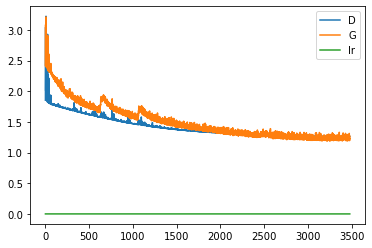

In [39]:
plt.plot(t.logger.container['D_loss'],label='D')
plt.plot(t.logger.container['G_loss'],label='G')
plt.plot(t.logger.container['lr'],label='lr')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


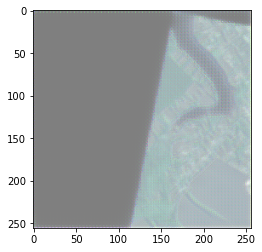

In [40]:
plt.imshow(t.logger.container['_no_avg_fakePlanet'][-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


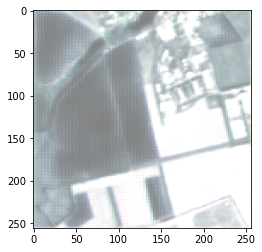

In [41]:
plt.imshow(t.logger.container['_no_avg_fakeSentinel'][-1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


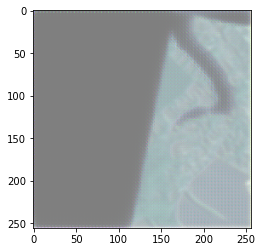

In [42]:
G.eval()
with torch.no_grad():
    pic = torch.tensor(t.sample[0]).to(DEVICE)
    out = G(pic.unsqueeze(0),None,1)
    out = G(out,None,0)
plt.imshow((out[0]/2+1).cpu().numpy()[1:].transpose(1,2,0))    

In [17]:
torch.save(t.D.state_dict(), f'models/D/{SAVE_NAME}.pth')
torch.save(t.G.state_dict(), f'models/G/{SAVE_NAME}.pth')

In [ ]:
path = 'models/HighResolutionNet32_none_15_nir_tci_multitemporal.pth'
#path = 'models/HighResolutionNet32_none_15_maskedicebce.pth'
path = 'models/HighResolutionNet32_none_15_adaptfrozen1-32_onecyclelr_0.0001_0.1_0.01.pth'
#path = None
finetune = True
unfreeze = slice(1,32)
model = load_model(config['model'].lower(), path=path, device=config['device'], channels=4)
model_version = 'adaptfrozen1-53_onecyclelr_0.0001_0.15_0.07'


if unfreeze:
    for p in model.parameters():
        p.requires_grad = False
    for m in list(model.modules())[unfreeze]:
        for p in m.parameters():
            p.requires_grad = True

if config['early_stopping']:
    
    save_path = f'models/chkpt_{config["model"]}_{config["weigths"]}_{config["epochs"]}_{model_version}_es.pt'
else:
    save_path = f'models/{config["model"]}_{config["weigths"]}_{config["epochs"]}_{model_version}.pth'
    
if path is not None and not finetune:
    save_path = path

In [52]:
for i,m in enumerate(list(model.modules())[1:]):
    print(i,m)

0 Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2 Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
3 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
4 ReLU(inplace=True)
5 Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [53]:
len(train_set), len(valid_set), len(test_set)

(106, 24, 40)

In [54]:
train_set[0][0].shape, train_set[0][1].shape

(torch.Size([4, 256, 256]), torch.Size([256, 256]))

In [55]:
valid_set[0][0].shape, valid_set[0][1].shape

(torch.Size([4, 256, 256]), torch.Size([256, 256]))

In [56]:
test_set[0][0].shape, test_set[0][1].shape

(torch.Size([4, 256, 256]), torch.Size([256, 256]))

In [31]:
criterion = MaskedDiceBCELoss(dice_weight=0.2, bce_weight=0.8)
#criterion = FocalLoss()
#criterion = FocalDiceBCELoss(0.1,0.2,0.7)
#criterion = MaskedLoss(criterion,base_weigth=1,aux_weigth=0)
criterion = EntropyDivergenceLoss(criterion,0.01,0.01)
metric = metrics.IoU(threshold=0.5)

class PLModel(pl.LightningModule):
    
    def __init__(self, model, lr):
        super(PLModel, self).__init__()
        self.model = model
        self.learning_rate = lr
        
        self.scores = pd.DataFrame()

    def forward(self, x, *args, **kwargs):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        xs, ys,zs,xt,yt,zt = batch
        
        y_hat = self(torch.cat([xs,xt]))
        ys_hat, yt_hat = y_hat[0], y_hat[1]
        loss = criterion(ys_hat,ys,zs,yt_hat,zt)
        
        score = metric(ys_hat, ys)
        adapt_score = metric(yt_hat,yt)
        result = {'loss': loss, 'train_iou': score,'adapt_iou':adapt_score}
        self.log('train_loss', loss)
        self.log('train_iou', score)
        return result
    
    def validation_step(self, batch, batch_idx):
        xs, ys,zs,xt,yt,zt = batch
        
        y_hat = self(torch.cat([xs,xt]))
        ys_hat, yt_hat = y_hat[0], y_hat[1]
        loss = criterion(ys_hat,ys,zs,yt_hat,zt)

        score = metric(ys_hat, ys)
        adapt_score = metric(yt_hat,yt)
        result = {'valid_loss': loss, 'val_iou': score,'val_adapt_iou':adapt_score}
        self.log('valid_loss', loss)
        self.log('valid_iou', score)
        self.log('adapt_iou',adapt_score)
        return result
    
    def test_step(self, batch, batch_idx):
        xs, ys,zs,xt,yt,zt = batch
        
        y_hat = self(torch.cat([xs,xt]))
        ys_hat, yt_hat = y_hat[0], y_hat[1]
        loss = criterion(ys_hat,ys,zs,yt_hat,zt)
        
        score = metric(ys_hat, ys)
        adapt_score = metric(yt_hat,yt)
        result = {'test_loss': loss, 'test_iou': score,'test_adapt_iou':adapt_score}
        self.log('test_loss', loss)
        self.log('test_iou', score)
        self.log('test_iou',adapt_score)
        return result
    
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_set, self.val_set = train_set, valid_set
        
        if stage == 'test' or stage is None:
            self.test_set = test_set
    
    def train_dataloader(self):
        return DataLoader(self.train_set,
                          shuffle=True,
                          batch_size=config['batch_size'],
                          pin_memory=True,
                          num_workers=8)
    
    def val_dataloader(self):
        return DataLoader(self.val_set,
                          batch_size=config['batch_size'],
                          pin_memory=True,
                          shuffle=False,
                          num_workers=8)
    
    def test_dataloader(self):
        return DataLoader(self.test_set,
                          batch_size=config['batch_size'],
                          pin_memory=True,
                          shuffle=False,
                          num_workers=8)
    
    def configure_optimizers(self):

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=config['lr'])

        sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                            config['lr'], 
                                            epochs=config['epochs'], 
                                            steps_per_epoch=len(train_set)//config['batch_size'])

        return (
            [optimizer],
            [{'scheduler': sched, 'interval': 'epoch', 'monitor': 'val_loss'}],
        )

In [32]:
pl_model = PLModel(model, config['lr'])
logger = pl.loggers.CSVLogger('logs', 
                              name='onecycle')

if config['early_stopping']:
    early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
       monitor='valid_loss',
       min_delta=config['es_delta'],
       patience=config['es_patience'],
       verbose=False,
       mode='min'
    )
    trainer = pl.Trainer(max_epochs=config['epochs'],
                         gpus=[1] if config['device']=='cuda:1' else None,
                         fast_dev_run=False,
                         logger=logger,
                         weights_save_path=None,
                         callbacks=[early_stop_callback]
                        )
else:

    trainer = pl.Trainer(max_epochs=config['epochs'],
                         gpus=[1] if config['device']=='cuda:1' else None,
                         fast_dev_run=False,
                         #overfit_batches=1,
                         logger=logger,
                         weights_save_path=None
                        )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [33]:
save_path

'models/HighResolutionNet32_none_15_adaptfrozen1-53_onecyclelr_0.0001_0.15_0.07.pth'

In [15]:
if finetune:
    pl_model.setup('fit')
    train_results = trainer.fit(pl_model)
    train_results
else:
    model = load_model(config['model'].lower(), save_path, config['device'], channels=4)
    pl_model = PLModel(model, config['lr'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type              | Params
--------------------------------------------
0 | model | HighResolutionNet | 29.5 M
--------------------------------------------
290 K     Trainable params
29.2 M    Non-trainable params
29.5 M    Total params
118.014   Total estimated model params size (MB)


In [16]:
pl_model.setup('test')
test_results = trainer.test(pl_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_iou': 0.30565086007118225, 'test_loss': 0.24667558073997498}
--------------------------------------------------------------------------------



In [17]:
torch.save(pl_model.model.state_dict(), save_path)

In [41]:
%%capture
model.eval()

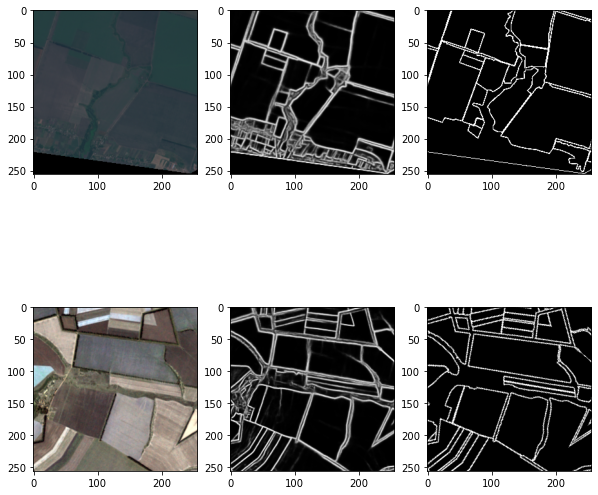

In [35]:
with torch.no_grad():
    fig, ax = plt.subplots(2,3, figsize=(10, 10))
    src, src_mask,_ ,targ,targ_mask,_= train_set[10]
    pred = pl_model.model.to(config['device'])(torch.cat([src.unsqueeze(0),targ.unsqueeze(0)]).to(config['device']))
    ax[0,0].imshow(src[1:].permute(1,2,0).numpy());
    ax[0,1].imshow(pred[0][0].cpu().detach().numpy(), cmap='gray');
    ax[0,2].imshow(src_mask.permute(0,1).numpy(), cmap='gray');
    ax[1,0].imshow(targ[1:].permute(1,2,0).numpy());
    ax[1,1].imshow(pred[1][0].cpu().detach().numpy(), cmap='gray');
    ax[1,2].imshow(targ_mask.permute(0,1).numpy(), cmap='gray');

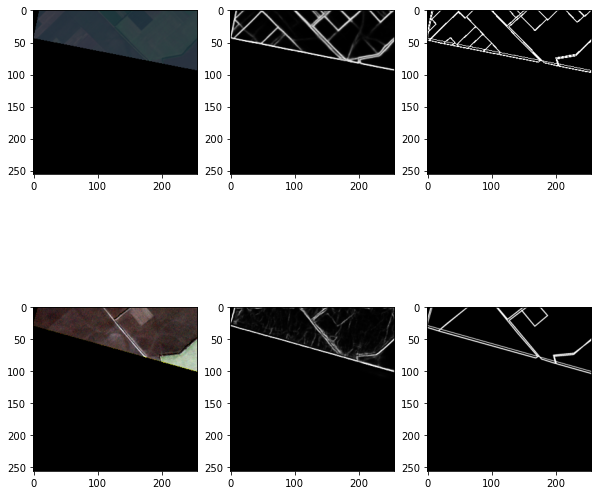

In [36]:
with torch.no_grad():
    fig, ax = plt.subplots(2,3, figsize=(10, 10))
    src, src_mask,_ ,targ,targ_mask,_= test_set[3]
    pred = pl_model.model.to(config['device'])(torch.cat([src.unsqueeze(0),targ.unsqueeze(0)]).to(config['device']))
    ax[0,0].imshow(src[1:].permute(1,2,0).numpy());
    ax[0,1].imshow(pred[0][0].cpu().detach().numpy(), cmap='gray');
    ax[0,2].imshow(src_mask.permute(0,1).numpy(), cmap='gray');
    ax[1,0].imshow(targ[1:].permute(1,2,0).numpy());
    ax[1,1].imshow(pred[1][0].cpu().detach().numpy(), cmap='gray');
    ax[1,2].imshow(targ_mask.permute(0,1).numpy(), cmap='gray');

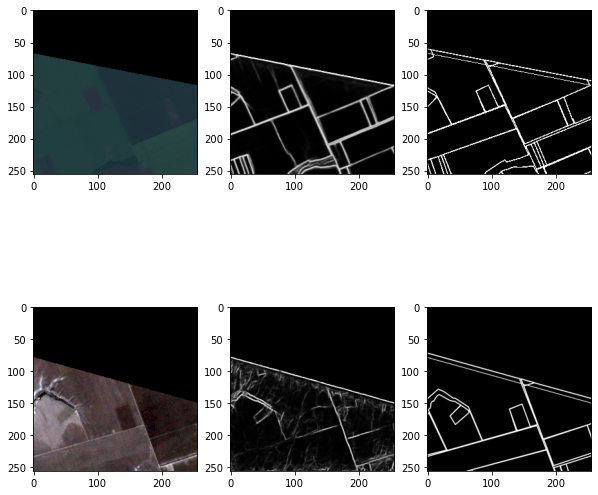

In [37]:
with torch.no_grad():
    fig, ax = plt.subplots(2,3, figsize=(10, 10))
    src, src_mask,_ ,targ,targ_mask,_= test_set[8]
    pred = pl_model.model.to(config['device'])(torch.cat([src.unsqueeze(0),targ.unsqueeze(0)]).to(config['device']))
    ax[0,0].imshow(src[1:].permute(1,2,0).numpy());
    ax[0,1].imshow(pred[0][0].cpu().detach().numpy(), cmap='gray');
    ax[0,2].imshow(src_mask.permute(0,1).numpy(), cmap='gray');
    ax[1,0].imshow(targ[1:].permute(1,2,0).numpy());
    ax[1,1].imshow(pred[1][0].cpu().detach().numpy(), cmap='gray');
    ax[1,2].imshow(targ_mask.permute(0,1).numpy(), cmap='gray');

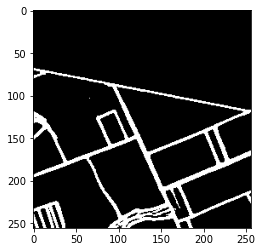

In [22]:
img = pred[0][0].cpu().detach().numpy()
plt.imshow(np.where(img>0.15, 255, 0), cmap='gray');

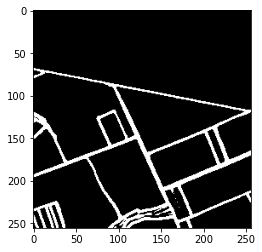

In [23]:
img = pred[0][0].cpu().detach().numpy()
plt.imshow(np.where(img>0.2, 255, 0), cmap='gray');

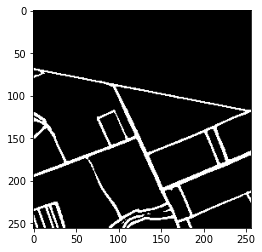

In [24]:
img = pred[0][0].cpu().detach().numpy()
plt.imshow(np.where(img>0.3, 255, 0), cmap='gray');

In [25]:
save_path


'models/HighResolutionNet32_none_15_adaptfrozen1-53_onecyclelr_0.0001_0.15_0.07.pth'

In [45]:
def rp(st=''): # attach to root path
    return os.path.join(r'/home/jovyan/work/notebooks/ied/research/supervised/',st)

m = get_metrics(
                model,
                aoi_path='/home/jovyan/work/notebooks/ied/data/Planet/test/20180410_082051_0f42_aoi.geojson',
                tile_path=rp('planet_code/evaluation_folder/20180410_082051_0f42_3B_AnalyticMS_cropped.tif'),
                gt_path=r'/home/jovyan/work/notebooks/ied/data/Planet/test/all_locs.geojson',
                buffer=8,
                planet=True,
                GAN=None,
                iou=0.8,
                device=config['device'],
                sentinel_scale=True
            )
print(m)

100%|██████████| 13/13 [00:03<00:00,  4.25it/s]
/opt/conda/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return convert(image, np.uint8, force_copy)


Writing raster: /home/jovyan/work/notebooks/ied/research/supervised/planet_code/evaluation_folder/20180410_082051_0f42_3B_AnalyticMS_cropped_prediction.tif


100%|██████████| 876/876 [00:00<00:00, 1784.41it/s]
/home/jovyan/work/notebooks/ied/research/supervised/adaptation1/mycode_planet/nikita_eval/dataset.py:194: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area!=df.area.max()] # it catches exterior of aoi as well :/
/home/jovyan/work/notebooks/ied/research/supervised/adaptation1/mycode_planet/nikita_eval/dataset.py:200: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area>min_poly_area]


Writing resulting polygons: /home/jovyan/work/notebooks/ied/research/supervised/planet_code/evaluation_folder/20180410_082051_0f42_3B_AnalyticMS_cropped_prediction_prediction.geojson


670it [00:04, 134.08it/s]

{'precision': 0.1970149224326131, 'recall': 0.18857142587755107, 'f_score': 0.19270072711385802}


0


/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


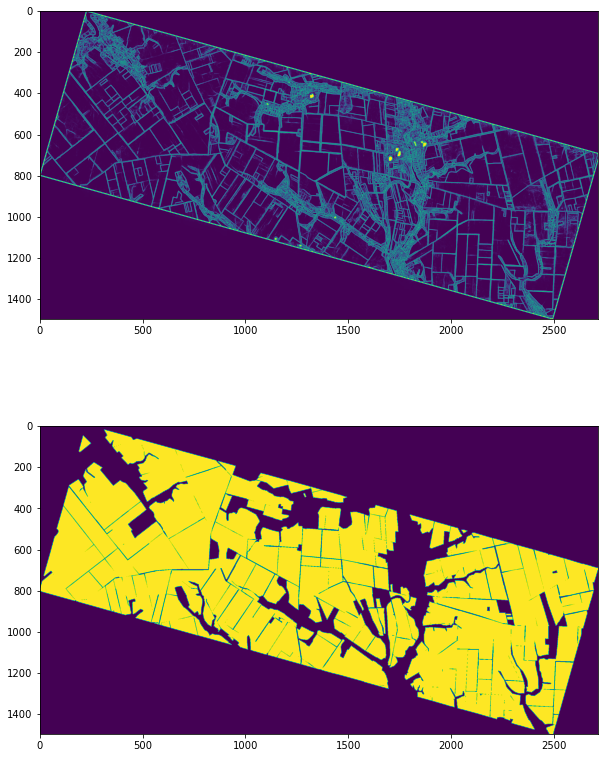

In [43]:
f,axes = plt.subplots(2,1,figsize=(10,14))
pred = rasterio.open(rp('planet_code/evaluation_folder/20180410_082051_0f42_3B_AnalyticMS_cropped_prediction.tif')).read()[0]
print(pred.min())
axes[0].imshow(pred)
axes[1].imshow(rasterio.open(rp('planet_code/evaluation_folder/20180410_082051_0f42_3B_AnalyticMS_cropped_prediction_gt.png')).read()[0])

In [28]:
m = get_metrics(
                model,
                aoi_path='/home/jovyan/work/notebooks/ied/data/Sentinel-2/valid/20170916_074939_0f17_edited_aoi.geojson',
                tile_path=rp('sentinel_code/evaluation_folder/T36UYA_20190606T083601_TCI_cropped.tif'),#r'/home/jovyan/work/notebooks/ied/research/uqp/uqp_cropped.tif',
                gt_path=r'/home/jovyan/work/notebooks/ied/data/Sentinel-2/valid/all_locs.geojson',
                buffer=8,
                planet=False,
                GAN=None,
                iou=0.8
            )
print(m)

100%|██████████| 13/13 [00:02<00:00,  4.54it/s]
/opt/conda/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return convert(image, np.uint8, force_copy)


Writing raster: /home/jovyan/work/notebooks/ied/research/supervised/sentinel_code/evaluation_folder/T36UYA_20190606T083601_TCI_cropped_prediction.tif


100%|██████████| 862/862 [00:00<00:00, 1892.31it/s]
/home/jovyan/work/notebooks/ied/research/supervised/adaptation1/mycode_planet/nikita_eval/dataset.py:194: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area!=df.area.max()] # it catches exterior of aoi as well :/
/home/jovyan/work/notebooks/ied/research/supervised/adaptation1/mycode_planet/nikita_eval/dataset.py:200: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area>min_poly_area]


Writing resulting polygons: /home/jovyan/work/notebooks/ied/research/supervised/sentinel_code/evaluation_folder/T36UYA_20190606T083601_TCI_cropped_prediction_prediction.geojson


601it [00:02, 293.51it/s]

{'precision': 0.06821963280832558, 'recall': 0.2329545322184925, 'f_score': 0.10553410281765502}


0


/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


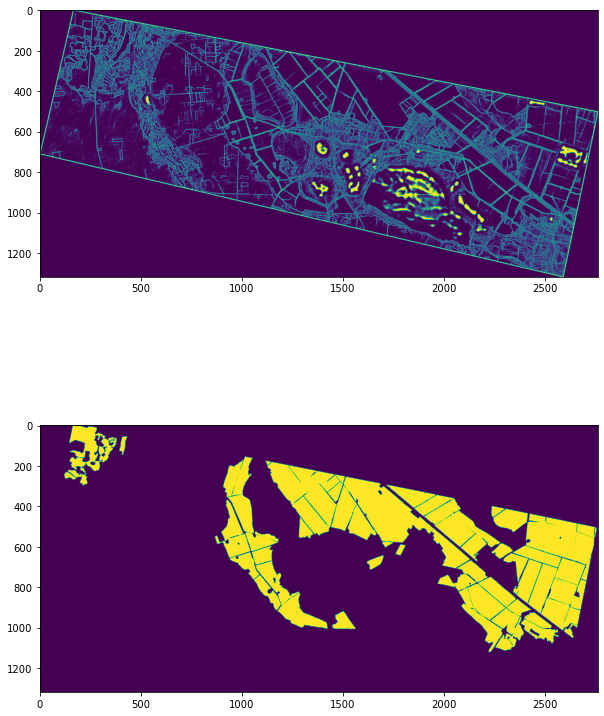

In [29]:
f,axes = plt.subplots(2,1,figsize=(10,14))
pred = rasterio.open(rp('sentinel_code/evaluation_folder/T36UYA_20190606T083601_TCI_cropped_prediction.tif')).read()[0]
print(pred.min())
axes[0].imshow(pred)
axes[1].imshow(rasterio.open(rp('sentinel_code/evaluation_folder/T36UYA_20190606T083601_TCI_cropped_prediction_gt.png')).read()[0])

In [31]:
with rasterio.open('/home/jovyan/work/notebooks/ied/research/supervised/planet_code/evaluation_folder/20180410_082051_0f42_3B_AnalyticMS_cropped.tif') as src:
    print(src.transform)
    print(src.transform*src.transform.scale(3.33))

| 3.00, 0.00, 298875.00|
| 0.00,-3.00, 5385138.00|
| 0.00, 0.00, 1.00|
| 9.99, 0.00, 298875.00|
| 0.00,-9.99, 5385138.00|
| 0.00, 0.00, 1.00|
